<img src="img/saturn_logo.png" width="300" />

# Parallel Inference

We are ready to scale up our inference task!

<img src="https://media.giphy.com/media/4H5nOUqX7FywOGpCF7/giphy.gif" alt="scaleup" style="width: 200px;"/>

We've done this before, but to refresh your memory, get connected to the cluster using the following code.

In [1]:
from dask_saturn import SaturnCluster
from dask.distributed import Client

cluster = SaturnCluster(
    n_workers = 3, 
    scheduler_size = 'medium', 
    worker_size = 'p32xlarge',
    nthreads = 8
)

client = Client(cluster)
client.wait_for_workers(3)
client

[2020-12-04 21:32:57] INFO - dask-saturn | Cluster is ready
[2020-12-04 21:32:57] INFO - dask-saturn | Registering default plugins
[2020-12-04 21:32:57] INFO - dask-saturn | {'tcp://10.0.0.218:33245': {'status': 'repeat'}, 'tcp://10.0.10.215:33649': {'status': 'repeat'}, 'tcp://10.0.3.161:46117': {'status': 'repeat'}}


Client Scheduler: tcp://d-steph-workshop-dask-pytorch-466b41db5a6b4fca8eb0c02a20d046a4.main-namespace:8786 Dashboard: https://d-steph-workshop-dask-pytorch-466b41db5a6b4fca8eb0c02a20d046a4.internal.saturnenterprise.io,Cluster Workers: 3 Cores: 24 Memory: 181.50 GB


In [2]:
%run -i setup1.py

We'll use the command above to get ourselves back to the state we need from Notebook 3.

***

## Assigning Objects to GPU Resources

If you are going to run any processes on GPU resources in a cluster, you need all your objects to be explicitly told this. Otherwise, it won't seek out GPU resources. However, if you use a functional setup (as we are going to do later) you'll need to do this INSIDE your function. Our architecture below will have all that written in. But before we go too complex, we should learn how that works in isolation.

This command is all you need to assign an object (a model, an image, etc) to a GPU-type resource. [The PyTorch docs can tell us more.](https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.device) So here's how we do it with the model:

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision import datasets, transforms, models
resnet = models.resnet50(pretrained=True)

resnet = resnet.to(device)

Now you try. What would you write to assign a transformed image (call it `img_t`) to a GPU resource? (*This image has already been created for you in the setup script.*)
We'll do this a few more times in the upcoming examples.

In [4]:
type(img_t)

torch.Tensor

Fill in the blanks in between `<<< >>>` marks to get the correct code, or click the ellipsis below to check your work.

In [ ]:
### FILL IN THE BLANKS ###

img_t = <<< FILL IN >>>

In [5]:
img_t = img_t.to(device)

## Preprocessing Images

Our goal here is to create a nicely streamlined workflow, including loading, transforming, batching, and labeling images, which we can then run in parallel.

In [6]:
import dask

@dask.delayed
def preprocess(path, fs=__builtins__):
    '''Ingest images directly from S3, apply transformations,
    and extract the ground truth and image identifier. Accepts
    a filepath. '''
    
    transform = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(250), 
        transforms.ToTensor(),
    ])

    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        nvis = transform(img)

    truth = re.search('dogs/Images/n[0-9]+-([^/]+)/n[0-9]+_[0-9]+.jpg', path).group(1)
    name = re.search('dogs/Images/n[0-9]+-[a-zA-Z-_]+/(n[0-9]+_[0-9]+).jpg', path).group(1)
    
    return [name, nvis, truth]

This function does a number of things for us.
* Open an image file from S3
* Apply transformations to image
* Retrieve a unique identifier for the image
* Retrieve the ground truth label for the image

But you'll notice that this has a `@dask.delayed` decorator, so we can queue it without it running immediately when called. Because of this, we can use some list comprehension strategies to create our batches and get them ready for our inference.

First, we break the list of images we have from our S3 filepath into chunks that will define the batches. (We defined `s3` when we connected to the S3 file storage in [Notebook 3](03-single-inference.ipynb), if you forgot.)

In [7]:
import toolz

s3fpath = 's3://saturn-public-data/dogs/Images/*/*.jpg'
batch_breaks = [list(batch) for batch in toolz.partition_all(60, s3.glob(s3fpath))]

What does one of our batches look like? It's a list of image paths!

In [8]:
batch_breaks[0][:5]

['saturn-public-data/dogs/Images/n02085620-Chihuahua/n02085620_10074.jpg',
 'saturn-public-data/dogs/Images/n02085620-Chihuahua/n02085620_10131.jpg',
 'saturn-public-data/dogs/Images/n02085620-Chihuahua/n02085620_10621.jpg',
 'saturn-public-data/dogs/Images/n02085620-Chihuahua/n02085620_1073.jpg',
 'saturn-public-data/dogs/Images/n02085620-Chihuahua/n02085620_10976.jpg']

In [9]:
image_batches = [[preprocess(x, fs=s3) for x in y] for y in batch_breaks]

In [10]:
@dask.delayed
def reformat(batch):
    flat_list = [item for item in batch]
    tensors = [x[1] for x in flat_list]
    names = [x[0] for x in flat_list]
    labels = [x[2] for x in flat_list]
    return [names, tensors, labels]
    
image_batches = [reformat(result) for result in image_batches]

If we want to get a nice visual representation of the tasks we have queued up, we can use the `.visualize()` method on a delayed object, like this. We've set up a lot of tasks in this one batch!

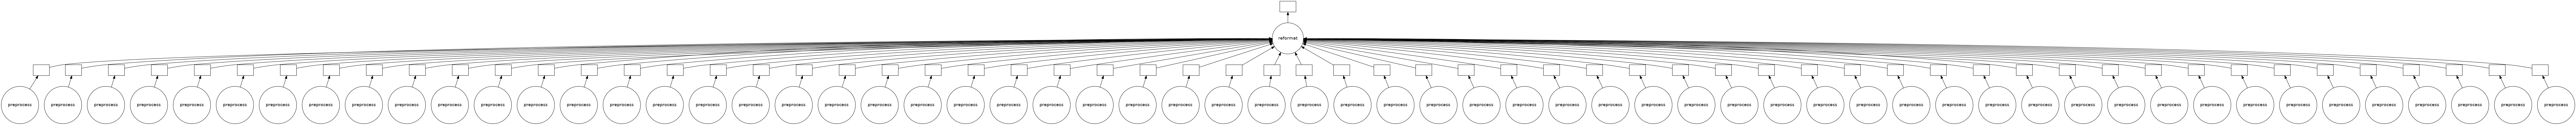

In [11]:
image_batches[0].visualize()

Now we have our images ready! But as you know, we really just have a list of tasks queued up that we're going to ask our cluster to complete later.

***

## Run the Model
We are ready to do the inference task! This is going to have a few steps, all of which are contained in functions described below, but we’ll talk through them so everything is clear, using just one batch as an example.

Our unit of work at this point is batches of 60 images at a time, which we created in the section above. They are all neatly arranged in lists so that we can work with them effectively.

### Stack Tensors
One thing we need to do with the lists is to “stack” the tensors. We could do this earlier in our process, but because we are using the Dask delayed decorator on the preprocessing, our functions actually do not know that they are receiving tensors until later in the process. Therefore, we’re delaying the “stacking” as well by putting it inside this function that comes after the preprocessing.


### One-Batch Example
In this next bit, we'll step through the elements of our inference function for one batch, before we do the scaled-up job.

First: snag one batch of our images to use as a test case.

In [12]:
from PIL import Image
import re
iteritem = image_batches[0].compute()

In [13]:
with s3.open('s3://saturn-public-data/dogs/imagenet1000_clsidx_to_labels.txt') as f:
    classes = [line.strip() for line in f.readlines()]

names, images, truelabels = iteritem

images = torch.stack(images) 

So now we have our tensors stacked so that batches can be passed to the model. We are going to retrieve our model, using syntax that will be very familiar from [Notebook 3](03-single-inference.ipynb).

In [14]:
resnet = models.resnet50(pretrained=True)
resnet = resnet.to(device)
resnet.eval()
images = images.to(device)
pred_batch = resnet(images)

We assign our image stack (just the batch we are working on) to the GPU and then run the inference, returning predictions for that batch.

***

## Result Evaluation

The predictions and truth we have so far, however, are not really human readable or comparable, so we’ll use the functions that follow to fix them up and get us interpretable results.

In [15]:
def evaluate_pred_batch(batch, gtruth, classes):
    ''' Accepts batch of images, returns human readable predictions. '''
    _, indices = torch.sort(batch, descending=True)
    percentage = torch.nn.functional.softmax(batch, dim=1)[0] * 100
    
    preds = []
    labslist = []
    for i in range(len(batch)):
        pred = [(classes[idx], percentage[idx].item()) for idx in indices[i][:1]]
        preds.append(pred)

        labs = gtruth[i]
        labslist.append(labs)
        
    return(preds, labslist)

preds, labslist = evaluate_pred_batch(pred_batch, truelabels, classes)

This takes our results from the model, and a few other elements, to return nice readable predictions and the probabilities the model assigned. From here, we’re nearly done! We want to pass our results back to S3 in a tidy, human readable way, so the rest of the function handles that. It will iterate over each image because these functionalities are not batch handling. `is_match` is one of our custom functions, which you can check out below.


In [16]:
import pickle

def is_match(la, ev):
    ''' Evaluate human readable prediction against ground truth. 
    (Used in both methods)'''
    if re.search(la.replace('_', ' '), str(ev).replace('_', ' ')):
        match = True
    else:
        match = False
    return(match)

for j in range(0, len(images)):
    predicted = preds[j]
    groundtruth = labslist[j]
    name = names[j]
    match = is_match(groundtruth, predicted)

    outcome = {'name': name, 'ground_truth': groundtruth, 'prediction': predicted, 'evaluation': match}

# Write each result to S3 directly - not active in this demo, this is only an example of how you could do it.
#     with s3.open(f"s3://fake-results-bucket/dogs/preds/{name}.pkl", "wb") as f:
#         pickle.dump(outcome, f)
        
print(outcome)

{'name': 'n02085620_2921', 'ground_truth': 'Chihuahua', 'prediction': [(b"151: 'Chihuahua',", 93.02682495117188)], 'evaluation': True}


There we go, that's one result from our batch.

## Put It All Together

Now, we aren’t going to patch together all these computations by hand, instead we have assembled them in one single delayed function that will do the work for us. Importantly, we can then map this across all our batches of images across the cluster! Can you spot all the tasks we have described above? 

Fill in the blanks in between `<<< >>>` marks to get the correct code, or click the ellipsis below to check your work.

In [17]:
def evaluate_pred_batch(batch, gtruth, classes):
    ''' Accepts batch of images, returns human readable predictions. '''
    _, indices = torch.sort(batch, descending=True)
    percentage = torch.nn.functional.softmax(batch, dim=1)[0] * 100
    
    preds = []
    labslist = []
    for i in range(len(batch)):
        pred = [(classes[idx], percentage[idx].item()) for idx in indices[i][:1]]
        preds.append(pred)

        labs = gtruth[i]
        labslist.append(labs)
        
    return(preds, labslist)

def is_match(la, ev):
    ''' Evaluate human readable prediction against ground truth. 
    (Used in both methods)'''
    if re.search(la.replace('_', ' '), str(ev).replace('_', ' ')):
        match = True
    else:
        match = False
    return(match)    


@dask.delayed
def run_batch_to_s3(iteritem):
    ''' Accepts iterable result of preprocessing, 
    generates inferences and evaluates. '''
    
    with s3.open('s3://saturn-public-data/dogs/imagenet1000_clsidx_to_labels.txt') as f:
        classes = [line.strip() for line in f.readlines()]
  
    names, images, truelabels = iteritem
    
    images = torch.stack(images)
    
    with torch.no_grad():
        # Set up model
        resnet = models.resnet50(pretrained=True)
        resnet = resnet.to(device)
        resnet.eval()

        # run model on batch
        images = images.to(device)
        pred_batch = resnet(images)
        
        #Evaluate batch
        preds, labslist = evaluate_pred_batch(pred_batch, truelabels, classes)

        #Organize prediction results
        for j in range(0, len(images)):
            predicted = preds[j]
            groundtruth = labslist[j]
            name = names[j]
            match = is_match(groundtruth, predicted)
            
            outcome = {'name': name, 'ground_truth': groundtruth, 'prediction': predicted, 'evaluation': match}

        return(names)

## Run the Job

If you think you've filled in everything correctly, now you can try running the tasks in parallel. If you get errors, check the hidden chunk for answers.

Notice that we're going to use client methods below to ensure that our tasks are distributed across the cluster, run, and then retrieved.

In [18]:
display(HTML(gpu_links))

In [ ]:
%%time

futures = client.map(run_batch_to_s3, image_batches) 
futures_gathered = client.gather(futures)
futures_computed = client.compute(futures_gathered, sync=False)

import logging

results = []
errors = []
for fut in futures_computed:
    try:
        result = fut.result()
    except Exception as e:
        errors.append(e)
        logging.error(e)
    else:
        results.extend(result)

When we run this block, we might want to go visit the Dask dashboard, to see our work as it runs.

## Lessons Learned

* You can apply `@dask.delayed` to your custom code to allow parallelization with nearly zero refactoring
* Objects that are needed for a parallel task on GPU need to be assigned to a GPU resource
* Passing tasks to the workers uses mapping across the cluster for peak efficiency

And, of course, having multiple workers makes the job a lot faster!

<img src="https://media.giphy.com/media/Ood1OSF92jubS/giphy.gif" alt="parallel" style="width: 250px;"/>

